In [ ]:
import pandas as pd

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel

import numpy as np
import matplotlib.pyplot as plt

#!pip install pyLDAvis
import pyLDAvis.gensim_models

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/norika_machome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
df_final = pd.read_csv("../data/csv/df_clean.csv")
df_final.head()

,paperId,docType,keywords,keywordsPlus,subjectSub1,subjectCat1,subjectCatExt,categoryHeading,abstract,year,...,location,orgNames,orgEnhanced1,orgEnhancedAll,fullName,researcherId,authorSeq,firstAuthorSource,abstract_word_count,contains_keyword
0,WOS:000400551000003,Article,"computational materials science,nanostructures...",NaN,Technology,"Materials Science, Multidisciplinary",Materials Science,Science & Technology,Nanomaterial-based ultra-low-energy device des...,2016,...,NaN,West Bengal Univ Technol,Maulana Abul Kalam Azad University of Technology,Maulana Abul Kalam Azad University of Technology,"Purkayastha, Tamoghna",FSQ-0224-2022,1,seq1_unique,199,True
1,WOS:000400701200001,Article,NaN,NaN,Physical Sciences,"Physics, Applied",Physics,Science & Technology,A challenge for constructing large circuits of...,2016,...,AP,IBM TJ Watson Res Ctr,International Business Machines (IBM),International Business Machines (IBM);IBM USA,"McKay, David C.",GWM-2403-2022,1,seq1_unique,124,True
2,WOS:000399549500014,Article,NaN,"PASTA-ULAM PROBLEM,1-F NOISE,THERMAL AGITATION...",Technology,"Computer Science, Theory & Methods","Computer Science,Instruments & Instrumentation...",Science & Technology,Fluctuations with 1/f spectrum stand for the f...,2016,...,AC,IMT Bucharest,National Institute Research & Development Micr...,National Institute Research & Development Micr...,"Mihaila, M.",FKV-4690-2022,1,seq1_unique,445,True
3,WOS:000397944800010,Article,"Quantum Key Distribution,Bell States,Quantum C...","PRIVACY AMPLIFICATION,CRYPTOGRAPHY,INFORMATION...",Technology,"Computer Science, Information Systems",Computer Science,Science & Technology,A quantum key distribution protocol with tradi...,2016,...,AC,Shenzhen Univ,Shenzhen University,Shenzhen University,"Wang, Ting",JUD-9931-2023,1,seq1_unique,137,True
4,WOS:000398221800009,Article,"quantum cryptography,authentication,key distri...",NaN,Technology,"Computer Science, Information Systems","Computer Science,Telecommunications",Science & Technology,"In this paper, we review a previous research p...",2016,...,NaN,Natl Engn Sch Tunis,Universite de Tunis-El-Manar,Universite de Tunis-El-Manar;Ecole Nationale d...,"Ghilen, Aymen",GAU-3999-2022,1,seq1_unique,126,True


In [29]:
from gensim.models.ldamodel import LdaModel
loaded_lda_model = LdaModel.load('../data/model/model_v01/lda_model_10.model')

In [31]:
#https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/48b93f3c-fb3f-472b-8a13-28a63a423d5f/content

# Initialize tokenizer, lemmatizer, and stopwords
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if pd.isna(text):
        return []
    tokens = tokenizer.tokenize(text.lower())
    tokens = [t for t in tokens if not t.isnumeric()]       # Remove pure numbers
    tokens = [t for t in tokens if len(t) > 1]              # Remove 1-char tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return tokens

# Preprocess each abstract as one document
docs = df_final['abstract'].apply(preprocess).tolist()

# Build bigrams model (with min_count=20)
bigram = Phrases(docs, min_count= 5, threshold=10)

# Append bigrams to documents
docs_with_bigrams = []
for doc in docs:
    bigrams_in_doc = [token for token in bigram[doc] if '_' in token]
    docs_with_bigrams.append(doc + bigrams_in_doc)

# Build trigram model (min_count and threshold can be tuned)
trigram = Phrases(docs_with_bigrams, min_count= 5, threshold=10)

# Append trigrams to documents
docs_with_trigrams = []
for doc in docs_with_bigrams:
    trigrams_in_doc = [token for token in trigram[doc] if '_' in token]
    docs_with_trigrams.append(doc + trigrams_in_doc)

# Create dictionary and filter extremes (remove tokens appearing <20 docs)
dictionary = Dictionary(docs_with_trigrams)
# dictionary.filter_extremes(no_below=20, no_above = 0.3) #no_above <- I remove this

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in docs_with_trigrams]

print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")


Number of unique tokens: 52595
Number of documents: 28005


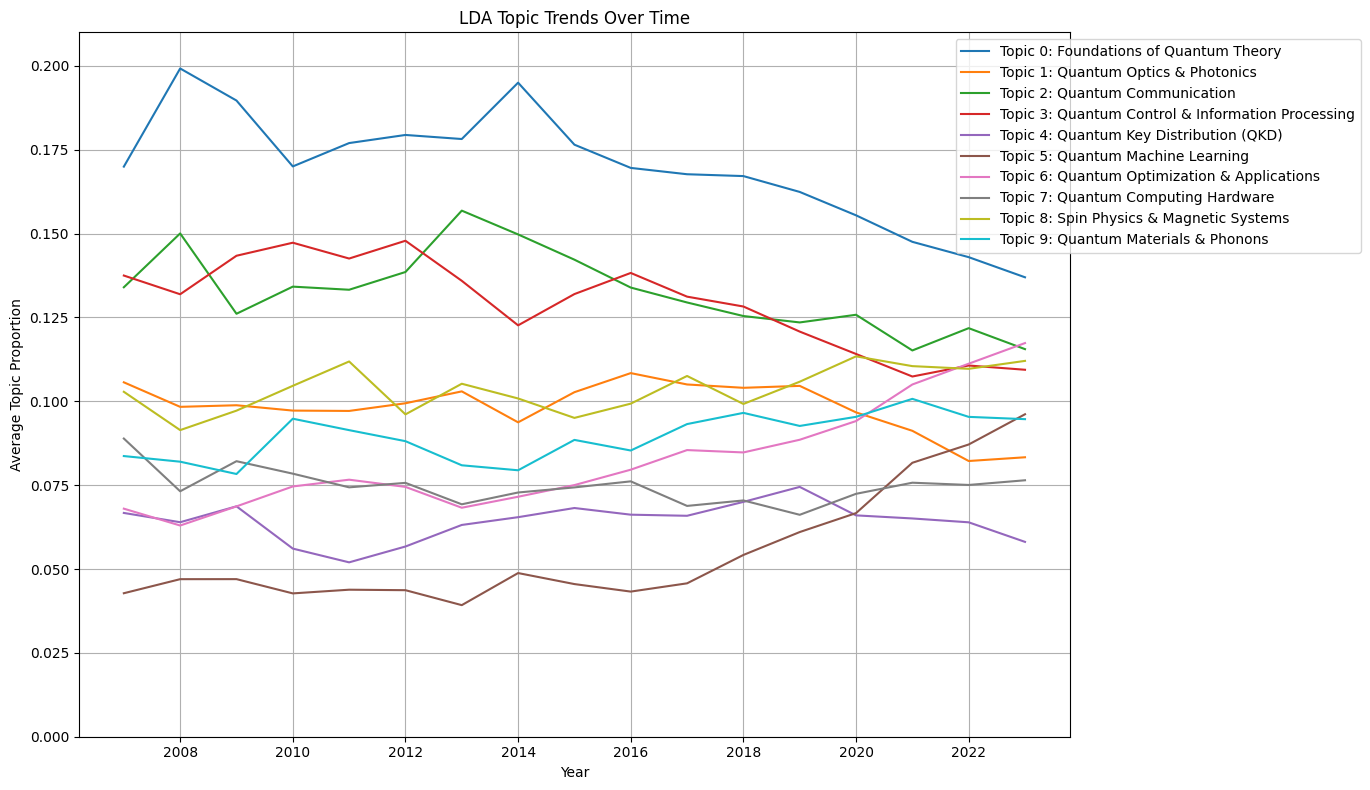

In [34]:

# Step 3: Get topic proportions per document using trained model
num_topics = loaded_lda_model.num_topics
doc_topics = [loaded_lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

# Step 4: Convert to dense matrix
topic_distributions = np.zeros((len(doc_topics), num_topics))
for i, doc in enumerate(doc_topics):
    for topic_id, prob in doc:
        topic_distributions[i][topic_id] = prob

# Step 5: Combine with year info
topic_df = pd.DataFrame(topic_distributions, columns=[f"topic_{i}" for i in range(num_topics)])
topic_df["year"] = df_final["year"].values

# Step 6: Compute average topic proportions per year
avg_topic_per_year = topic_df.groupby("year").mean().reset_index()

# Step 7: Plot
plt.figure(figsize=(14, 8))

# Human-readable topic names
topic_names = [
    "Foundations of Quantum Theory",
    "Quantum Optics & Photonics",
    "Quantum Communication",
    "Quantum Control & Information Processing",
    "Quantum Key Distribution (QKD)",
    "Quantum Machine Learning",
    "Quantum Optimization & Applications",
    "Quantum Computing Hardware",
    "Spin Physics & Magnetic Systems",
    "Quantum Materials & Phonons"
]

for i in range(num_topics):
    plt.plot(avg_topic_per_year["year"], avg_topic_per_year[f"topic_{i}"], label=f"Topic {i}: {topic_names[i]}")

plt.xlabel("Year")
plt.ylabel("Average Topic Proportion")
plt.title("LDA Topic Trends Over Time")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))  # Adjusted for longer legend labels
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.21)
plt.show()


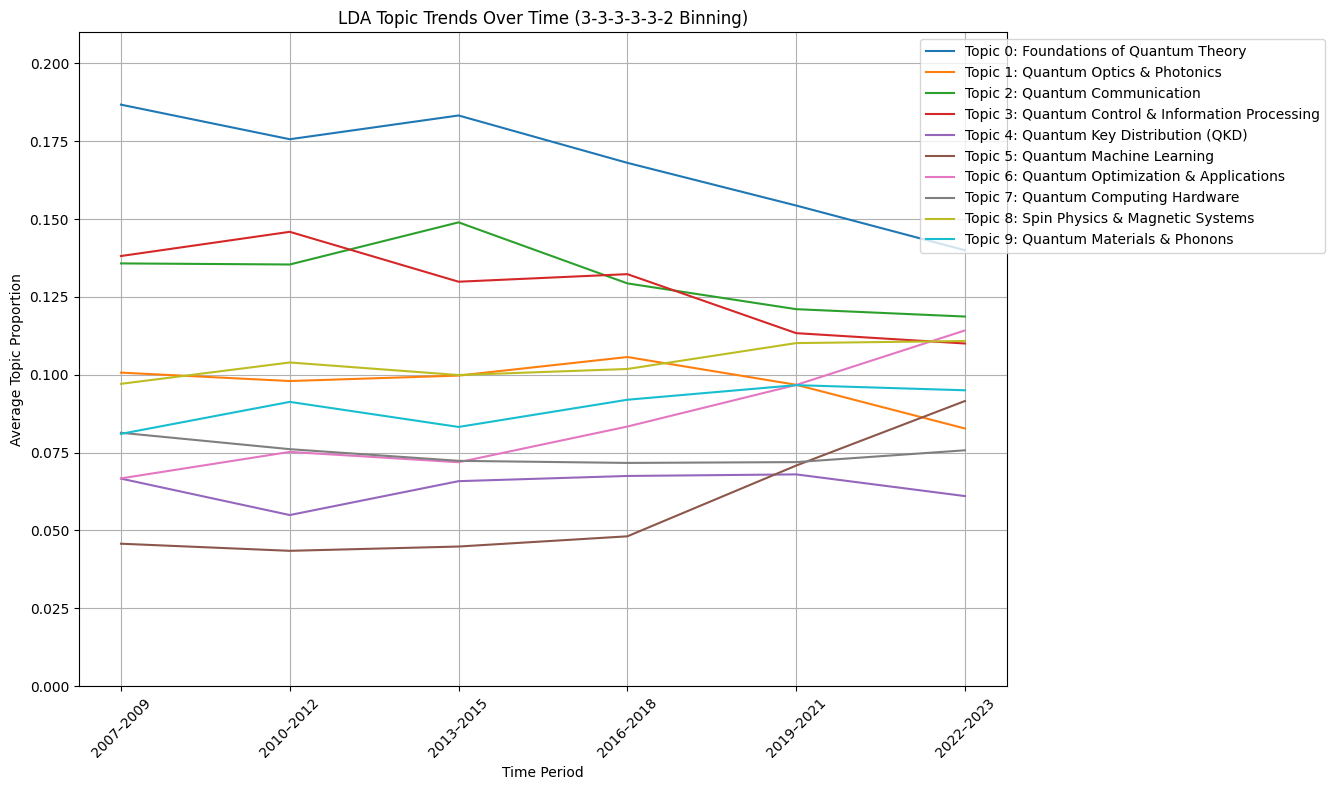

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 3: Get topic proportions per document using trained model
num_topics = loaded_lda_model.num_topics
doc_topics = [loaded_lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

# Step 4: Convert to dense matrix
topic_distributions = np.zeros((len(doc_topics), num_topics))
for i, doc in enumerate(doc_topics):
    for topic_id, prob in doc:
        topic_distributions[i][topic_id] = prob

# Step 5: Combine with year info
topic_df = pd.DataFrame(topic_distributions, columns=[f"topic_{i}" for i in range(num_topics)])
topic_df["year"] = df_final["year"].values

# Step 5b: Assign custom 3-3-3-3-3-2 year ranges
def assign_year_range(year):
    if 2007 <= year <= 2009:
        return "2007–2009"
    elif 2010 <= year <= 2012:
        return "2010–2012"
    elif 2013 <= year <= 2015:
        return "2013–2015"
    elif 2016 <= year <= 2018:
        return "2016–2018"
    elif 2019 <= year <= 2021:
        return "2019–2021"
    elif 2022 <= year <= 2023:
        return "2022–2023"
    else:
        return "Other"

topic_df["year_range"] = topic_df["year"].apply(assign_year_range)

# Step 6: Compute average topic proportions per year range
avg_topic_per_range = topic_df.groupby("year_range").mean().reset_index()

# Optional: sort ranges properly
ordered_ranges = ["2007–2009", "2010–2012", "2013–2015", "2016–2018", "2019–2021", "2022–2023"]
avg_topic_per_range["year_range"] = pd.Categorical(avg_topic_per_range["year_range"], categories=ordered_ranges, ordered=True)
avg_topic_per_range = avg_topic_per_range.sort_values("year_range")

# Step 8: Plot
plt.figure(figsize=(14, 8))

for i in range(num_topics):
    plt.plot(avg_topic_per_range["year_range"], avg_topic_per_range[f"topic_{i}"], label=f"Topic {i}: {topic_names[i]}")

plt.xlabel("Time Period")
plt.ylabel("Average Topic Proportion")
plt.title("LDA Topic Trends Over Time (3-3-3-3-3-2 Binning)")
plt.xticks(rotation=45)
plt.ylim(0, 0.21)
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


Countries included in plots: ['Peoples R China', 'USA', 'Germany', 'United Kingdom', 'Japan', 'Netherlands']


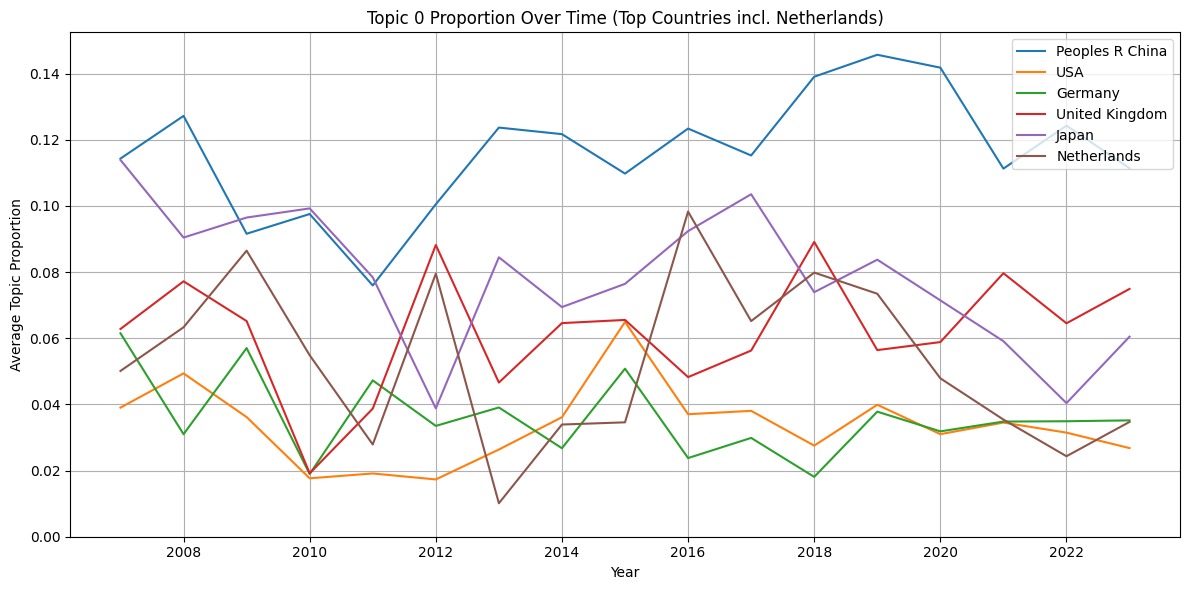

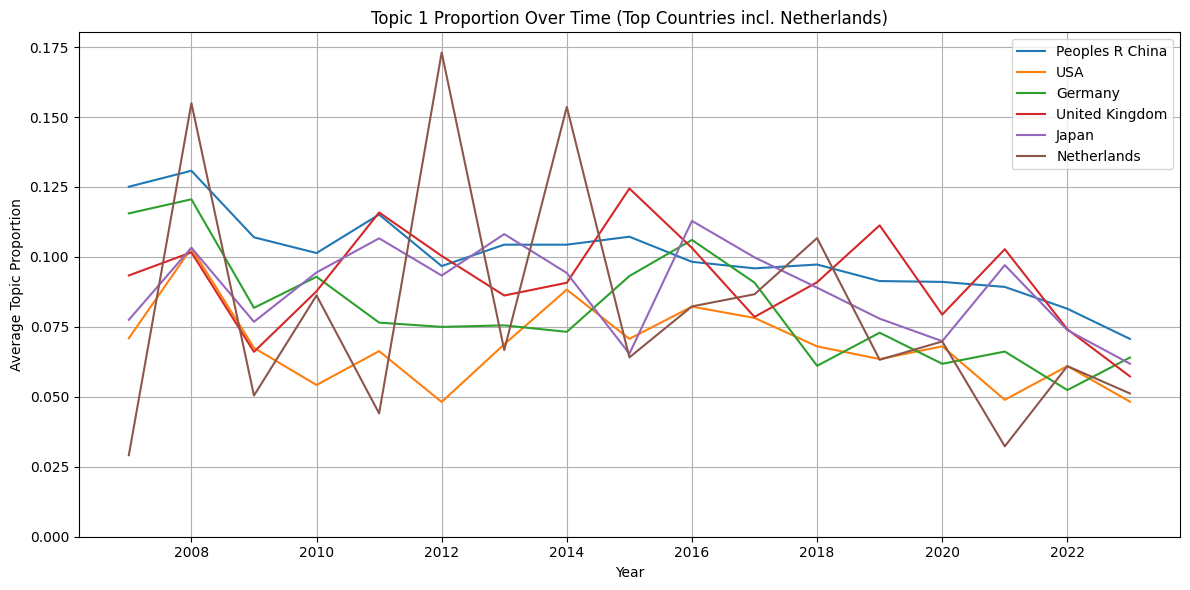

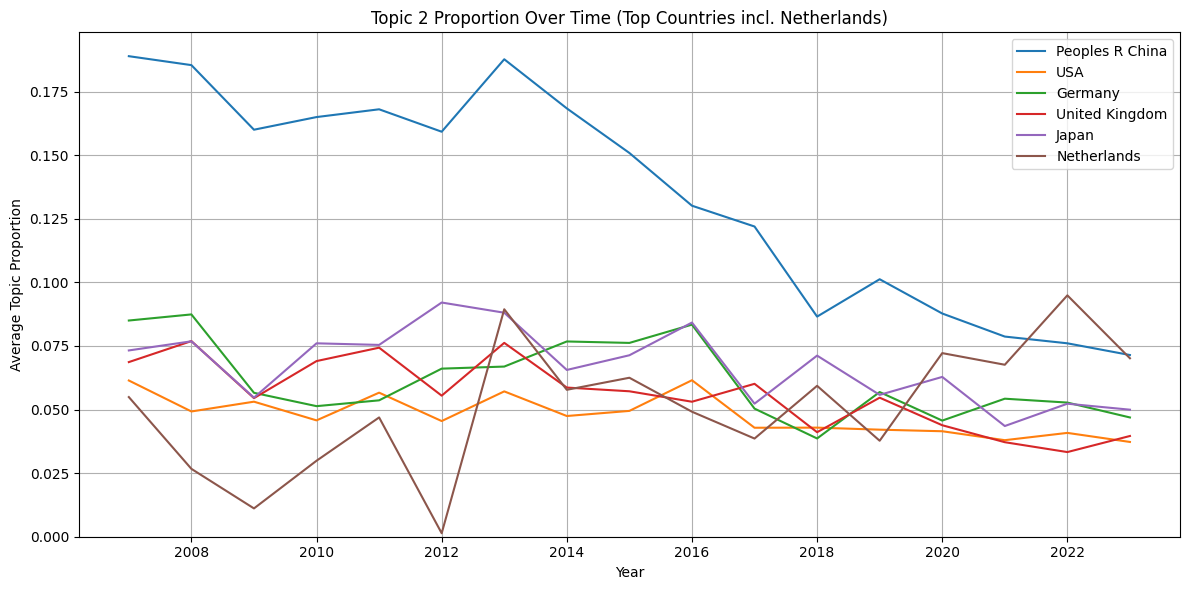

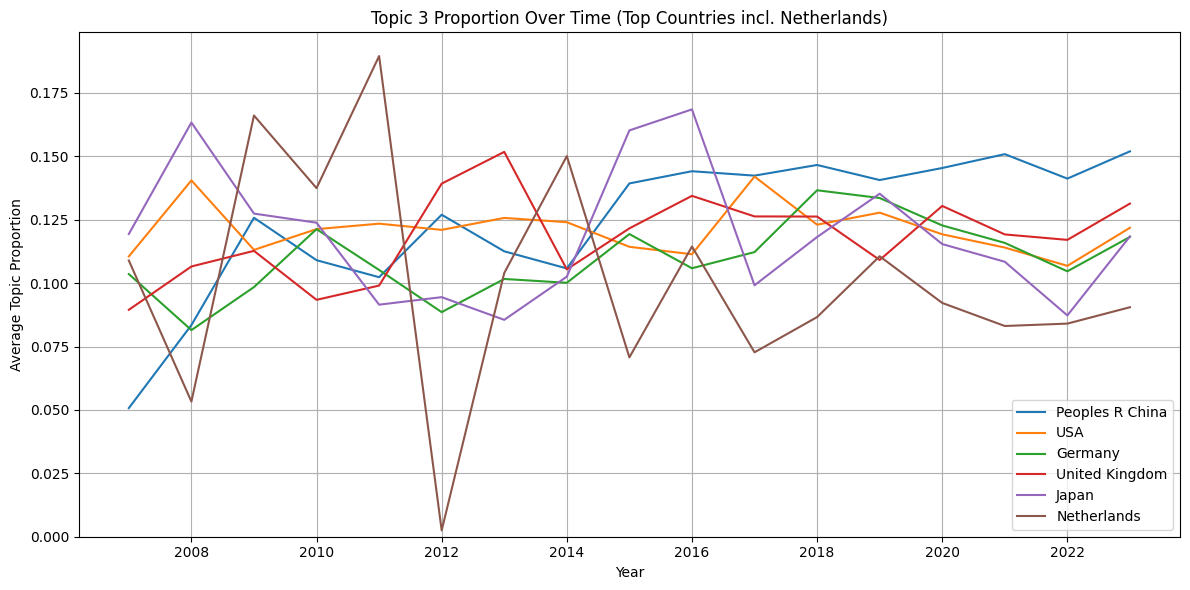

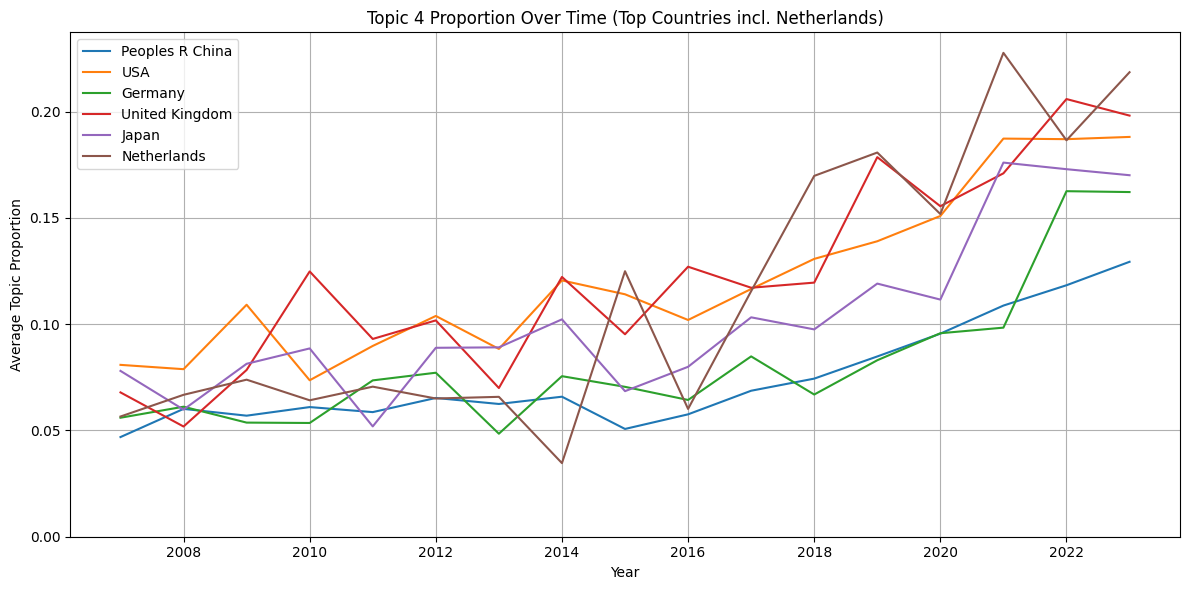

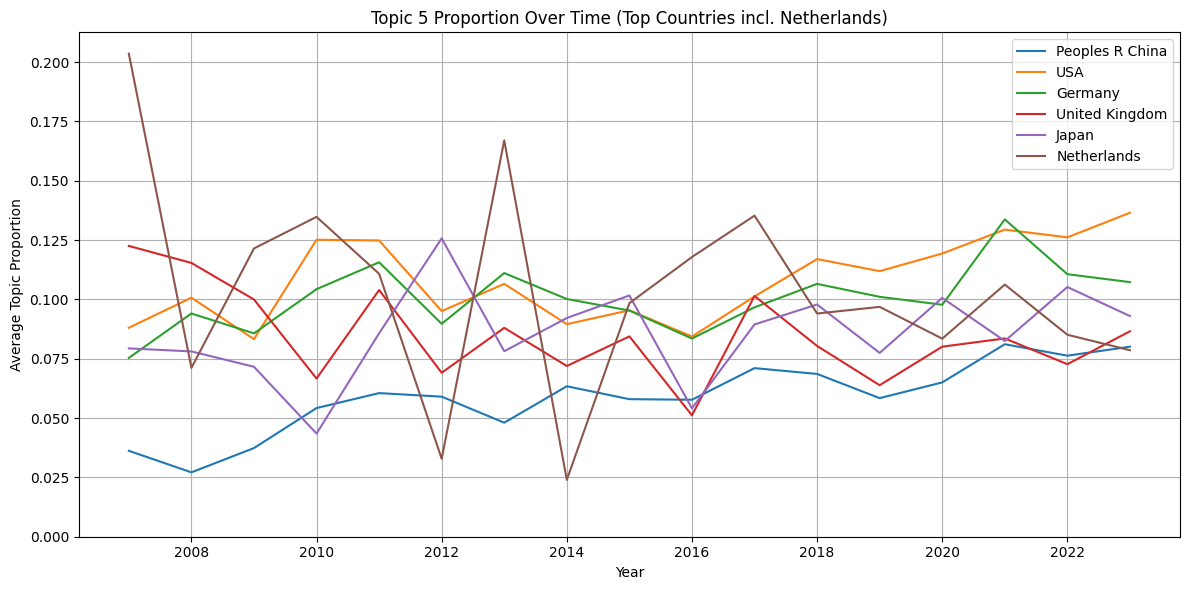

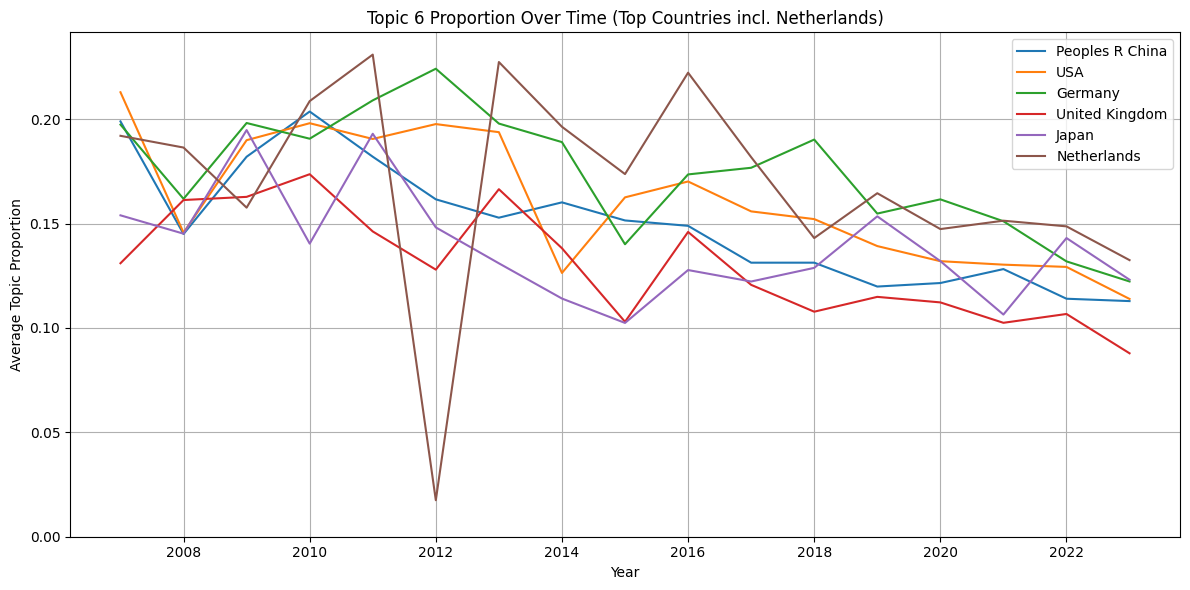

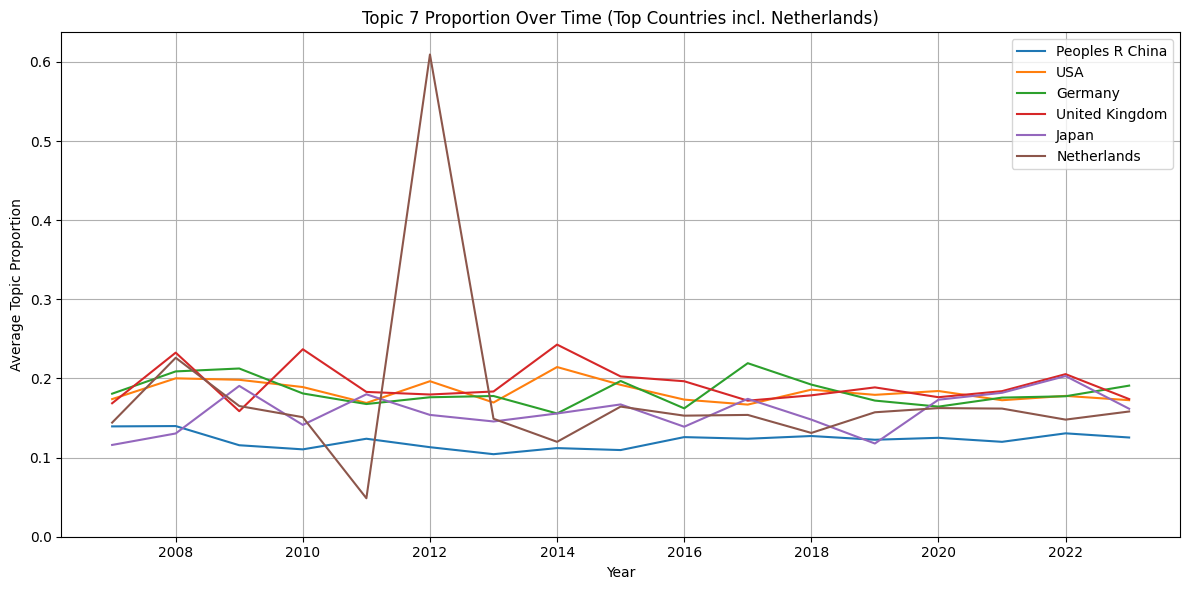

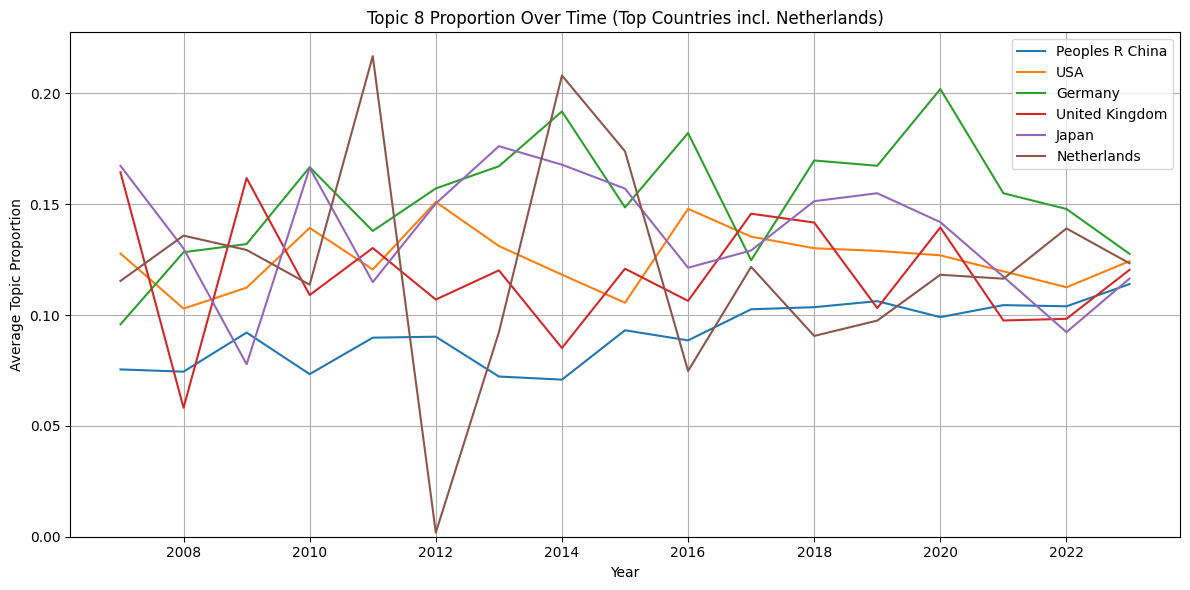

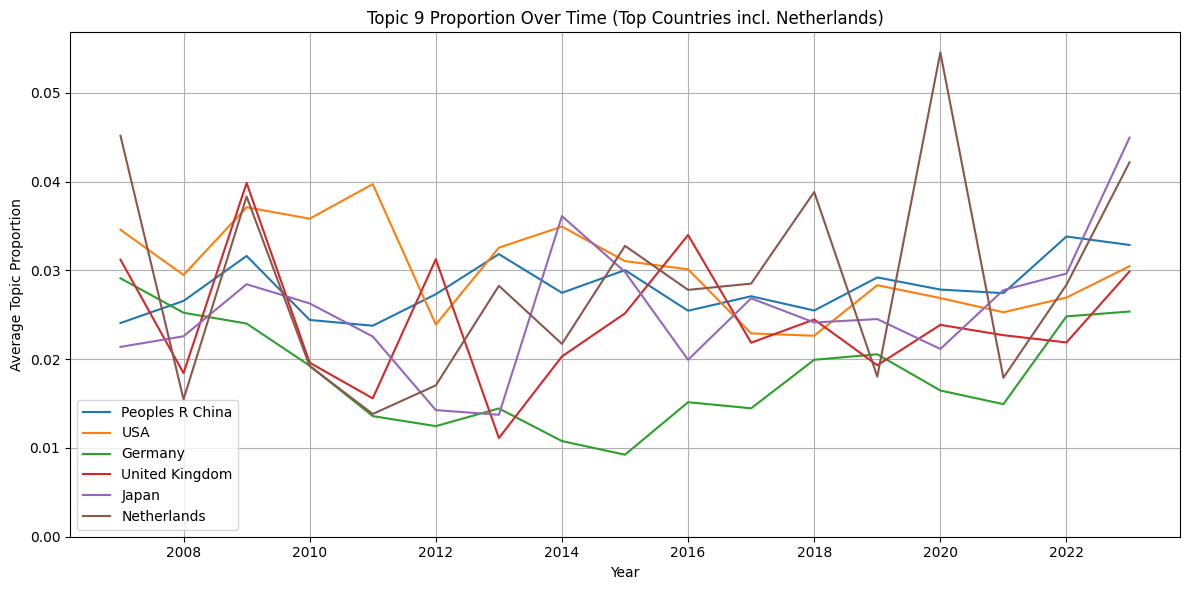

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create DataFrame for topic distributions and meta info
topic_df = pd.DataFrame(topic_distributions, columns=[f"topic_{i}" for i in range(topic_distributions.shape[1])])
topic_df["year"] = df_final["year"].values
topic_df["country_raw"] = df_final["country"].values

# Step 2: Clean country data (split multi-country entries)
topic_df = topic_df.dropna(subset=["country_raw"])
topic_df["country"] = topic_df["country_raw"].str.split(";")
topic_df = topic_df.explode("country")
topic_df["country"] = topic_df["country"].str.strip()

# Step 3: Normalize country names
def fix_uk(country):
    return "United Kingdom" if country.lower() in ["uk", "england", "scotland", "wales", "northern ireland"] else country
topic_df["country"] = topic_df["country"].apply(fix_uk)

# Step 4: Get top 5 countries + ensure Netherlands is included
top_countries = topic_df["country"].value_counts().nlargest(5).index.tolist()
if "Netherlands" not in top_countries:
    top_countries.append("Netherlands")
print("Countries included in plots:", top_countries)

# Step 5: Group by year and country
avg_topic_by_country_year = (
    topic_df.groupby(["year", "country"])
    .mean(numeric_only=True)
    .reset_index()
)

# Step 6: Plot topic trends per top country
num_topics = topic_distributions.shape[1]
for topic_id in range(num_topics):
    plt.figure(figsize=(12, 6))
    for country in top_countries:
        subset = avg_topic_by_country_year[avg_topic_by_country_year["country"] == country]
        if not subset.empty:
            plt.plot(subset["year"], subset[f"topic_{topic_id}"], label=country)
    plt.title(f"Topic {topic_id} Proportion Over Time (Top Countries incl. Netherlands)")
    plt.xlabel("Year")
    plt.ylabel("Average Topic Proportion")
    plt.ylim(bottom=0)  # Set y-axis to start from 0
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


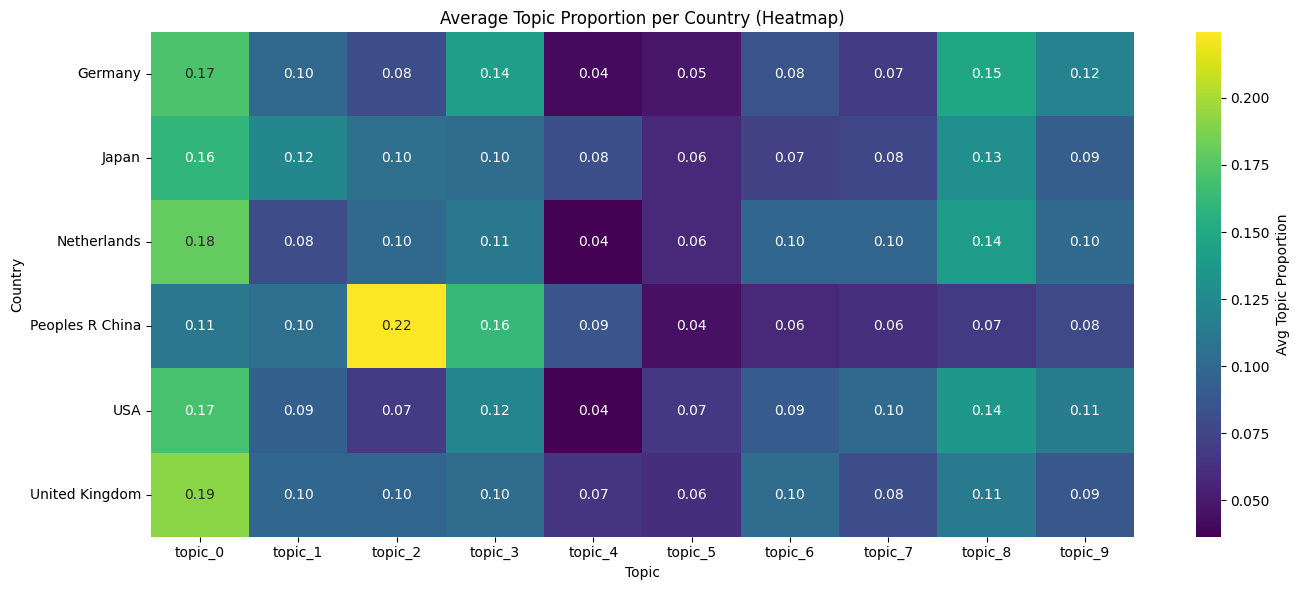

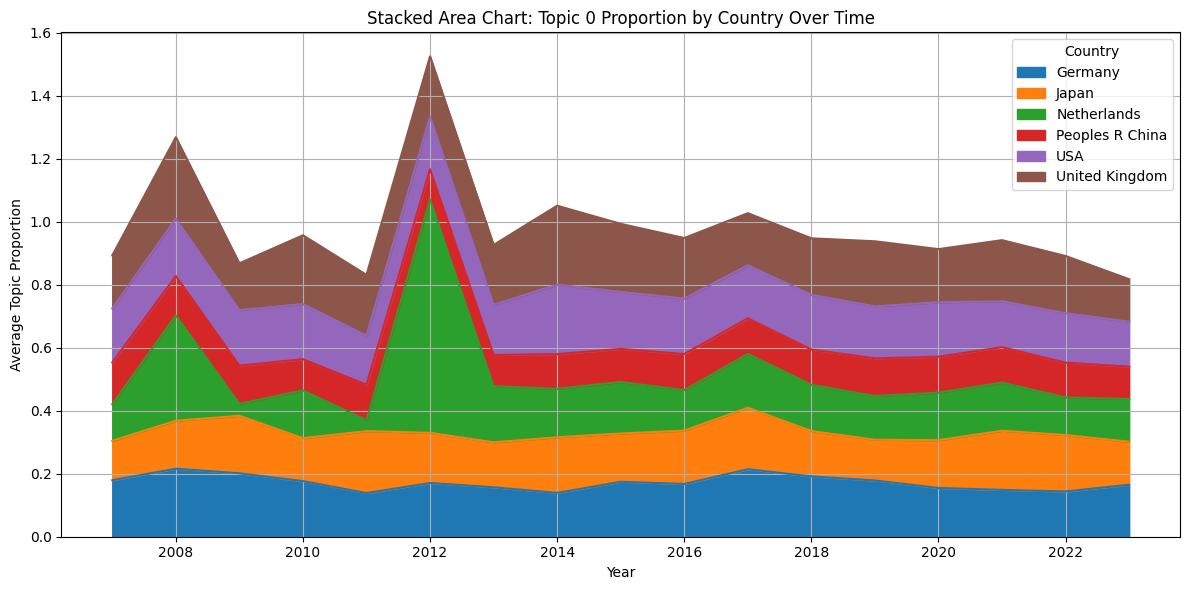

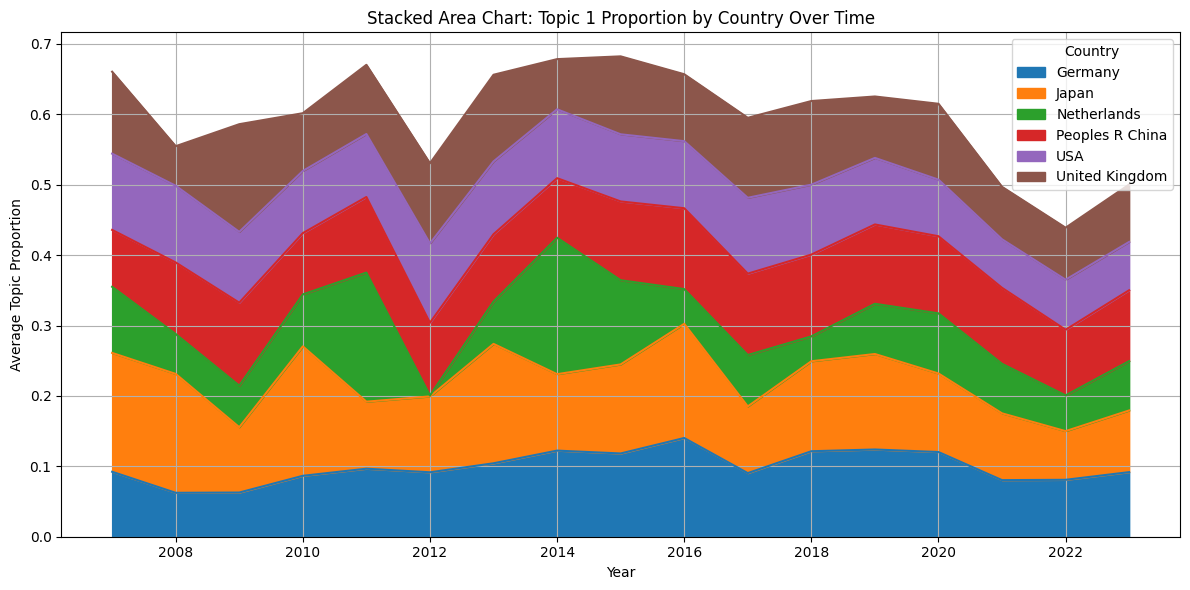

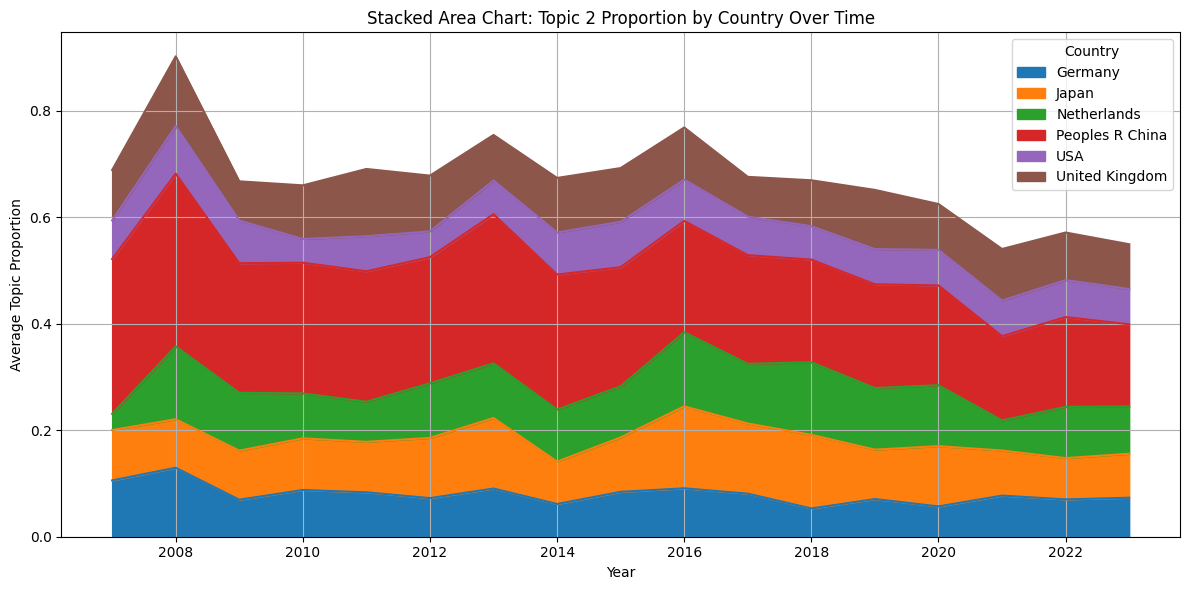

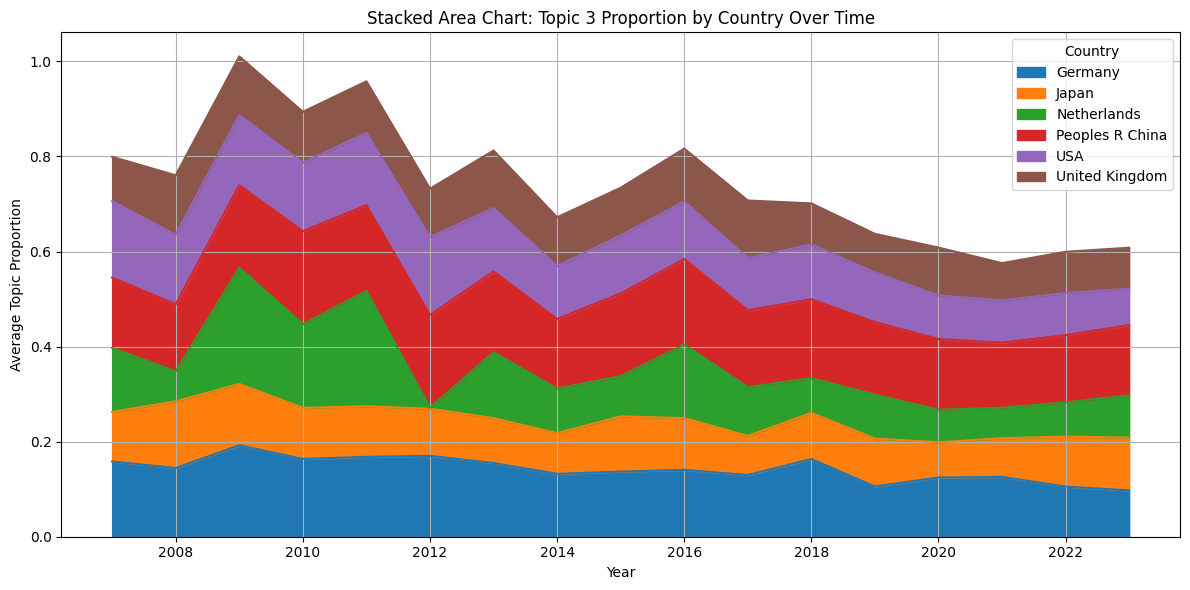

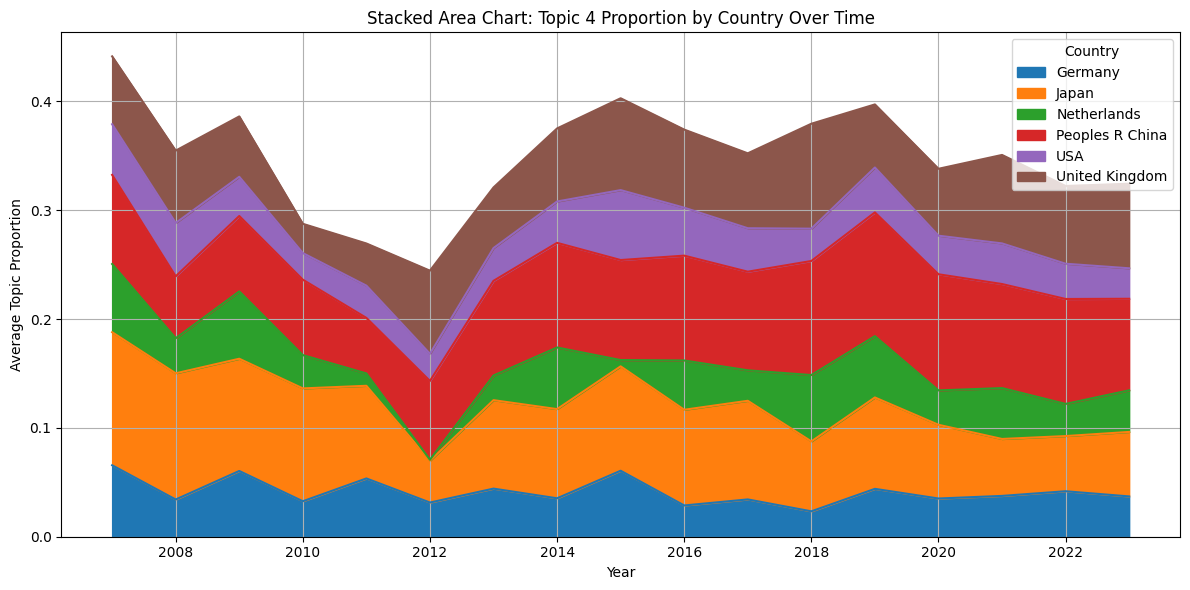

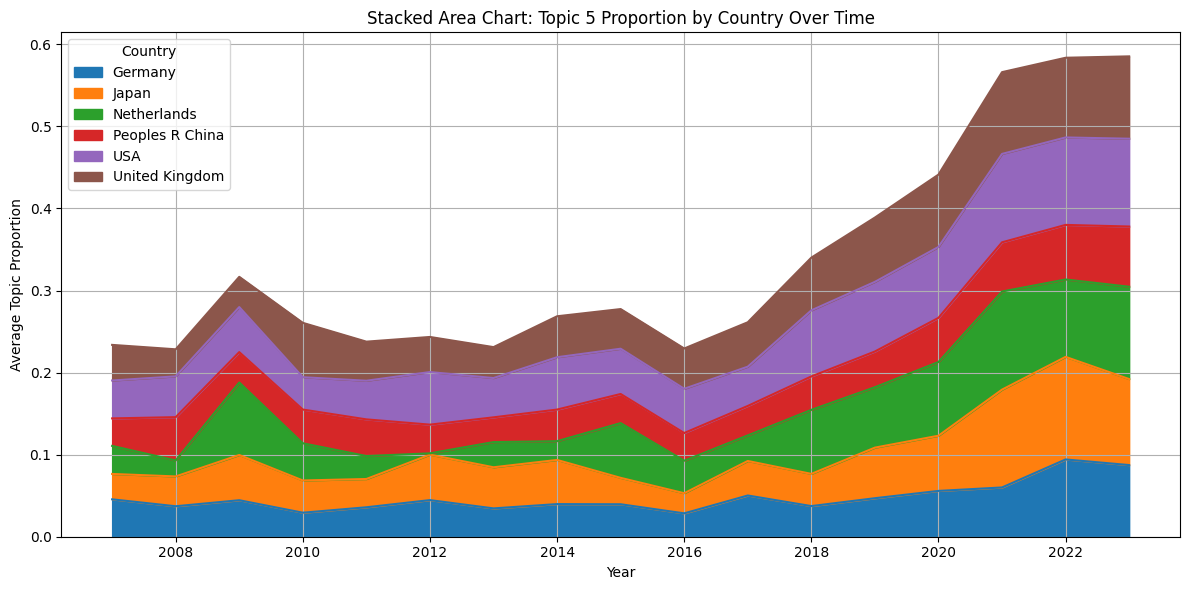

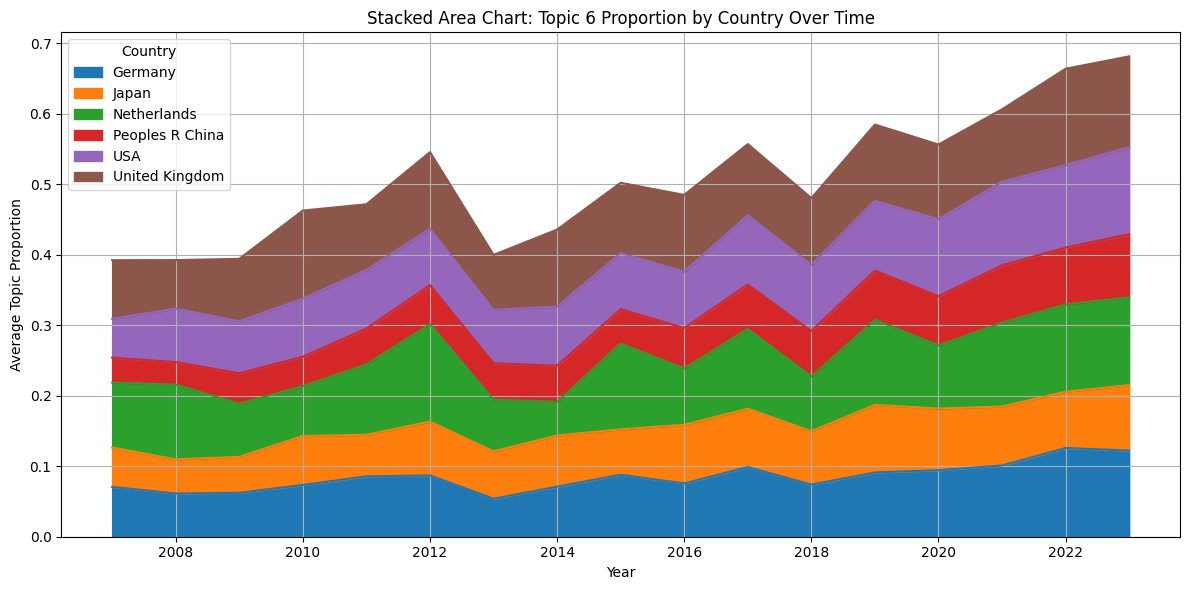

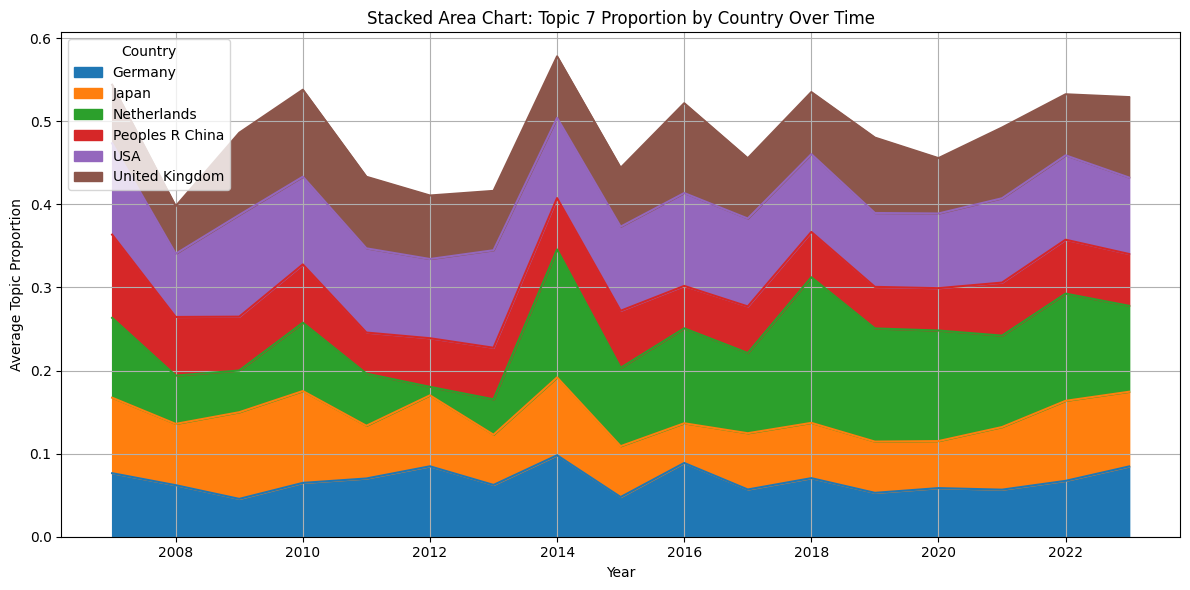

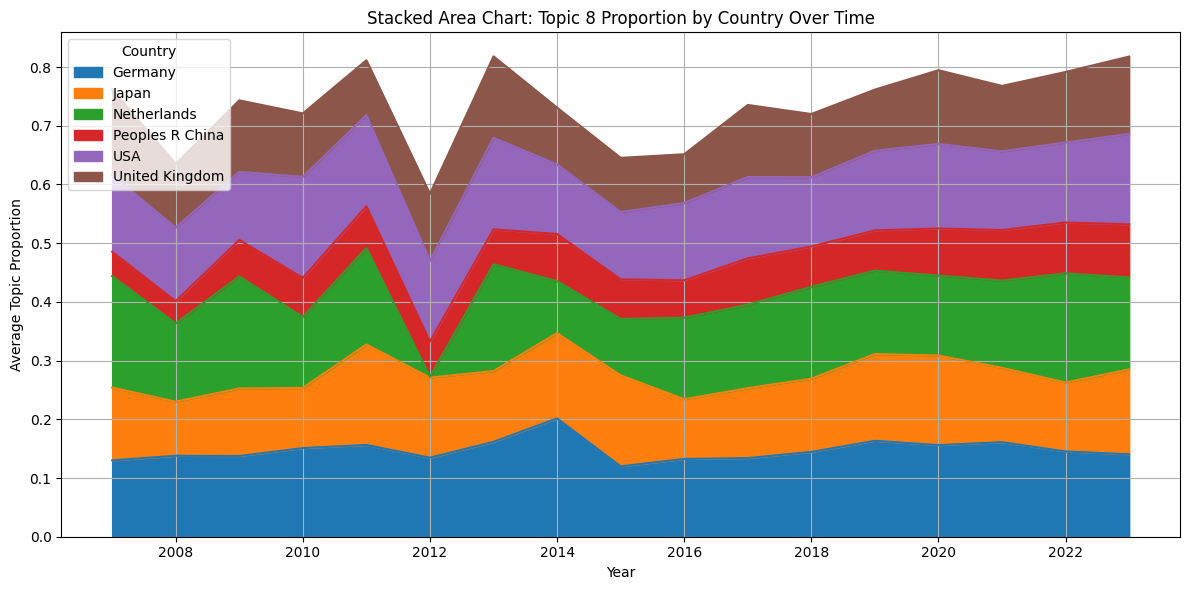

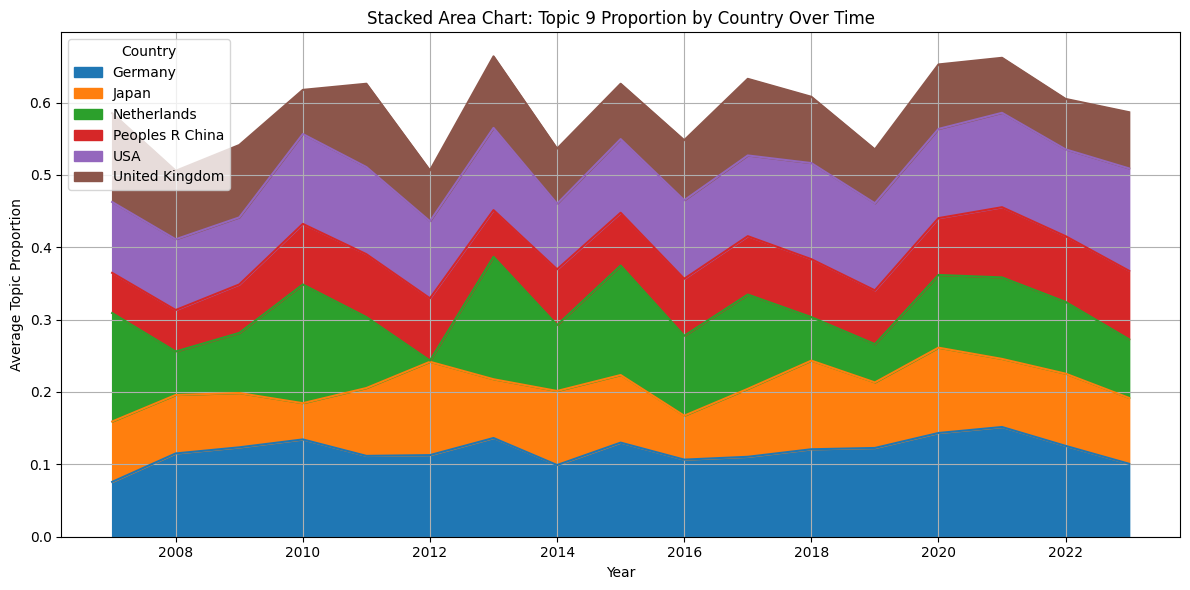

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you already have:
# - topic_distributions (NumPy array, shape: [n_docs, n_topics])
# - df_final (with 'year' and 'country' columns)

# Step 1: Create DataFrame for topic proportions and metadata
topic_df = pd.DataFrame(topic_distributions, columns=[f"topic_{i}" for i in range(topic_distributions.shape[1])])
topic_df["year"] = df_final["year"].values
topic_df["country_raw"] = df_final["country"].values

# Step 2: Clean and explode multi-country entries
topic_df = topic_df.dropna(subset=["country_raw"])
topic_df["country"] = topic_df["country_raw"].str.split(";")
topic_df = topic_df.explode("country")
topic_df["country"] = topic_df["country"].str.strip()

# Step 3: Normalize UK variants
def fix_uk(country):
    return "United Kingdom" if country.lower() in ["uk", "england", "scotland", "wales", "northern ireland"] else country
topic_df["country"] = topic_df["country"].apply(fix_uk)

# Step 4: Determine top 5 countries + always include Netherlands
top_countries = topic_df["country"].value_counts().nlargest(5).index.tolist()
if "Netherlands" not in top_countries:
    top_countries.append("Netherlands")

# Step 5: Group by year and country
avg_topic_by_country_year = (
    topic_df.groupby(["year", "country"])
    .mean(numeric_only=True)
    .reset_index()
)

# Step 6: Filter to selected countries
filtered_df = avg_topic_by_country_year[avg_topic_by_country_year["country"].isin(top_countries)]

# --------------- Heatmap ------------------
# Melt data for heatmap
melted = filtered_df.melt(
    id_vars=["year", "country"],
    value_vars=[f"topic_{i}" for i in range(topic_distributions.shape[1])],
    var_name="topic",
    value_name="proportion"
)

# Pivot for heatmap (avg across years)
heatmap_data = melted.pivot_table(index="country", columns="topic", values="proportion", aggfunc="mean")

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Avg Topic Proportion'})
plt.title("Average Topic Proportion per Country (Heatmap)")
plt.xlabel("Topic")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# --------------- Stacked Area Chart ------------------
# Pivot for area chart: year x country x topic
for topic_id in range(topic_distributions.shape[1]):
    topic_col = f"topic_{topic_id}"
    topic_stack = filtered_df.pivot(index="year", columns="country", values=topic_col).fillna(0)

    plt.figure(figsize=(12, 6))
    topic_stack.plot.area(stacked=True, ax=plt.gca())
    plt.title(f"Stacked Area Chart: Topic {topic_id} Proportion by Country Over Time")
    plt.xlabel("Year")
    plt.ylabel("Average Topic Proportion")
    plt.ylim(bottom=0)
    plt.legend(title="Country")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
df_clean = pd.read_csv("../data/csv/df_clean.csv")

# Filter for year 2012 and entries that mention 'Netherlands' in the country field
df_clean["year"] = pd.to_numeric(df_clean["year"], errors='coerce')  # Ensure year is numeric
df_clean["country"] = df_clean["country"].astype(str)  # Ensure country is string

# Apply filter
sample_nl_2012 = df_clean[
    (df_clean["year"] == 2012) &
    (df_clean["country"].str.contains("Netherlands", case=False, na=False))
]

# View first 5 rows
display(sample_nl_2012[["title", "abstract", "country", "year"]].head())

,title,abstract,country,year
5405,Transformed statistical distance measures and ...,Most multivariate statistical techniques are b...,Netherlands,2012


In [17]:
df_clean

,paperId,docType,keywords,keywordsPlus,subjectSub1,subjectCat1,subjectCatExt,categoryHeading,abstract,year,...,location,orgNames,orgEnhanced1,orgEnhancedAll,fullName,researcherId,authorSeq,firstAuthorSource,abstract_word_count,contains_keyword
0,WOS:000400551000003,Article,"computational materials science,nanostructures...",NaN,Technology,"Materials Science, Multidisciplinary",Materials Science,Science & Technology,Nanomaterial-based ultra-low-energy device des...,2016,...,NaN,West Bengal Univ Technol,Maulana Abul Kalam Azad University of Technology,Maulana Abul Kalam Azad University of Technology,"Purkayastha, Tamoghna",FSQ-0224-2022,1,seq1_unique,199,True
1,WOS:000400701200001,Article,NaN,NaN,Physical Sciences,"Physics, Applied",Physics,Science & Technology,A challenge for constructing large circuits of...,2016,...,AP,IBM TJ Watson Res Ctr,International Business Machines (IBM),International Business Machines (IBM);IBM USA,"McKay, David C.",GWM-2403-2022,1,seq1_unique,124,True
2,WOS:000399549500014,Article,NaN,"PASTA-ULAM PROBLEM,1-F NOISE,THERMAL AGITATION...",Technology,"Computer Science, Theory & Methods","Computer Science,Instruments & Instrumentation...",Science & Technology,Fluctuations with 1/f spectrum stand for the f...,2016,...,AC,IMT Bucharest,National Institute Research & Development Micr...,National Institute Research & Development Micr...,"Mihaila, M.",FKV-4690-2022,1,seq1_unique,445,True
3,WOS:000397944800010,Article,"Quantum Key Distribution,Bell States,Quantum C...","PRIVACY AMPLIFICATION,CRYPTOGRAPHY,INFORMATION...",Technology,"Computer Science, Information Systems",Computer Science,Science & Technology,A quantum key distribution protocol with tradi...,2016,...,AC,Shenzhen Univ,Shenzhen University,Shenzhen University,"Wang, Ting",JUD-9931-2023,1,seq1_unique,137,True
4,WOS:000398221800009,Article,"quantum cryptography,authentication,key distri...",NaN,Technology,"Computer Science, Information Systems","Computer Science,Telecommunications",Science & Technology,"In this paper, we review a previous research p...",2016,...,NaN,Natl Engn Sch Tunis,Universite de Tunis-El-Manar,Universite de Tunis-El-Manar;Ecole Nationale d...,"Ghilen, Aymen",GAU-3999-2022,1,seq1_unique,126,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28000,WOS:000660500300003,Review,"particle physics,quantum machine learning,quan...","OPTIMIZATION,ALGORITHMS",Technology,"Computer Science, Artificial Intelligence","Computer Science,Science & Technology - Other ...",Science & Technology,Machine learning has been used in high energy ...,2021,...,AP,Univ Wisconsin,University of Wisconsin System,University of Wisconsin System;University of W...,"Guan, Wen",KFZ-6090-2024,1,seq1_unique,112,True
28001,WOS:001078602300001,Article,"magnetism,magnonics,spin waves,yttrium iron ga...","SPIN,CONSTANTS",Technology,"Materials Science, Multidisciplinary","Materials Science,Physics",Science & Technology,We propose and experimentally demonstrate a me...,2021,...,NaN,Univ Oxford,University of Oxford,University of Oxford,"Fung, T. C.",AAV-8854-2020,1,seq1_unique,69,True
28002,WOS:001080866000001,Article,"single photon emitters,time-dependent spectros...","SINGLE-PHOTON EMISSION,RABI OSCILLATIONS,QUANT...",Technology,"Materials Science, Multidisciplinary","Materials Science,Physics",Science & Technology,Color centers in hexagonal boron nitride show ...,2021,...,BC,Univ Munster,University of Munster,University of Munster,"Groll, Daniel",GCJ-5221-2022,1,seq1_unique,112,True
28003,WOS:001004068600002,Article,"Wave equation,solver,quantum-computing algorithm",NaN,Technology,"Computer Science, Theory & Methods","Computer Science,Physics",Science & Technology,"In the last few years, several quantum algorit...",2021,...,NaN,CERFACS,CERFACS,CERFACS,"Suau, Adrien",HCO-7825-2022,1,seq1_unique,184,True
